<a href="https://colab.research.google.com/github/moon0825/Yoga-Pose-classification-model/blob/main/Yoga_Poses_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#yoga pose Dataset path
#https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset
#Use media-pipe to extract pose skeleton values from the data.
#Based on that value, it is the code to find the best ML model through Pycaret, store the model, and predict it.
#Kaggle saves the dataset to Google Drive and loads the compressed file for use

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install tqdm
!pip install mediapipe
#media-pipe 0.8.11

In [ ]:
!pip install pycaret==2.3.10

In [ ]:
!pip install xgboost==1.6.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive_path = '/content/drive/MyDrive/프로젝트/Yoga-Poses'

In [ ]:
yoga_path = drive_path + '/archive.zip'
!cp "$yoga_path" .
!unzip 'archive.zip'

In [ ]:
#Load the csv file that you saved to the drive
yoga_train_path = drive_path + '/fitness_poses_csvs_out_basic.csv'
!cp "$yoga_train_path" .

yoga_test_path = drive_path + '/fitness_poses_csvs_out_TEST.csv'
!cp "$yoga_test_path" .

In [ ]:
# Folder with images to use as target poses for classification.
#
# Images should repesent terminal states of desired pose classes.
images_in_folder = '/content/DATASET/TRAIN'

# Output folders for bootstrapped images and CSVs. Image will have a predicted
# Pose rendering and can be used to remove unwanted samples.
images_out_folder = 'fitness_poses_images_out_basic'

# Output CSV path to put bootstrapped poses to. This CSV will be used by the
# demo App.
#
# Output CSV format:
#   sample_00001,pose_class_1,x1,y1,z1,x2,y2,z2,...,x33,y33,z33
#   sample_00002,pose_class_2,x1,y1,z1,x2,y2,z2,...,x33,y33,z33
#   ...
#
csv_out_path = 'fitness_poses_csvs_out_basic.csv'

In [ ]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

help(mp_pose.Pose)

In [ ]:
import csv
import cv2
import numpy as np
import os
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


with open(csv_out_path, 'w') as csv_out_file:
  csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

  # Folder names are used as pose class names.
  pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])

  for pose_class_name in pose_class_names:
    print('Bootstrapping ', pose_class_name, file=sys.stderr)

    if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
      os.makedirs(os.path.join(images_out_folder, pose_class_name))

    image_names = sorted([
        n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
        if not n.startswith('.')])
    for image_name in tqdm.tqdm(image_names, position=0):
      # Load image. 함수화 시키기
      input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
      input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

      # Initialize fresh pose tracker and run it.
      with mp_pose.Pose(
              static_image_mode=True,
              model_complexity=2,
              enable_segmentation=True,
              min_detection_confidence=0.5) as pose_tracker:
        result = pose_tracker.process(image=input_frame)
        pose_landmarks = result.pose_landmarks
      # Save image with pose prediction (if pose was detected).
      output_frame = input_frame.copy()
      if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)
      output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
      cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
      
      # Save landmarks.
      if pose_landmarks is not None:
        # Check the number of landmarks and take pose landmarks.
        assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

        # Map pose landmarks from [0, 1] range to absolute coordinates to get
        # correct aspect ratio.
        frame_height, frame_width = output_frame.shape[:2]
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])

        # Write pose sample to CSV.
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()
        csv_out_writer.writerow([image_name, pose_class_name] + pose_landmarks)

In [ ]:
!cp "./fitness_poses_csvs_out_basic.csv" "$drive_path"
!cp -r "fitness_poses_images_out_basic" "$drive_path"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing

# Using Pycaret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *

In [ ]:
yp_df = pd.read_csv("fitness_poses_csvs_out_basic.csv",header=None)
yp_df = yp_df.rename(columns={0:'name', 1:'pose'})

In [ ]:
yp_data_df = yp_df.drop(['name'], axis=1)

In [ ]:
yp_data_df

In [ ]:
model = setup(data=yp_data_df, 
              target='pose', 
              train_size=0.7, # default value
              session_id=9,
              use_gpu=True) # Random seed

# Optimal Model Using Pycaret
|index|Model|Accuracy|AUC|Recall|Prec\.|F1|Kappa|MCC|TT \(Sec\)|
|---|---|---|---|---|---|---|---|---|---|
|lightgbm|Light Gradient Boosting Machine|0\.8682|0\.9775|0\.8653|0\.8785|0\.8664|0\.8334|0\.8365|1\.058|
|xgboost|Extreme Gradient Boosting|0\.8529|0\.9764|0\.849|0\.8637|0\.8505|0\.814|0\.8174|2\.197|
|et|Extra Trees Classifier|0\.8433|0\.9666|0\.8374|0\.8494|0\.8415|0\.8017|0\.8041|1\.067|
|lr|Logistic Regression|0\.8404|0\.9463|0\.8399|0\.8489|0\.8391|0\.7989|0\.8015|2\.239|
|rf|Random Forest Classifier|0\.8239|0\.9641|0\.817|0\.8314|0\.821|0\.7771|0\.7802|1\.016|
|gbc|Gradient Boosting Classifier|0\.8182|0\.9619|0\.811|0\.8287|0\.8163|0\.7699|0\.7728|4\.225|
|knn|K Neighbors Classifier|0\.7628|0\.9375|0\.7626|0\.7725|0\.7636|0\.7016|0\.7034|0\.421|
|svm|SVM - Linear Kernel|0\.7365|0\.0|0\.7345|0\.7828|0\.7297|0\.6681|0\.681|0\.117|
|dt|Decision Tree Classifier|0\.7198|0\.8216|0\.7133|0\.7307|0\.7182|0\.6451|0\.6481|0\.04|
|ridge|Ridge Classifier|0\.6893|0\.0|0\.6856|0\.697|0\.6874|0\.6062|0\.6086|0\.059|
|lda|Linear Discriminant Analysis|0\.5686|0\.8167|0\.5569|0\.5807|0\.5673|0\.4539|0\.4564|0\.201|
|ada|Ada Boost Classifier|0\.5547|0\.7834|0\.5492|0\.59|0\.5567|0\.4358|0\.4416|0\.282|
|qda|Quadratic Discriminant Analysis|0\.5437|0\.7089|0\.5263|0\.5603|0\.5283|0\.4194|0\.4285|0\.08|
|dummy|Dummy Classifier|0\.2538|0\.5|0\.2|0\.0645|0\.1028|0\.0|0\.0|0\.01|
|nb|Naive Bayes|0\.086|0\.3544|0\.1112|0\.0368|0\.0508|-0\.1221|-0\.1292|0\.024|

In [ ]:
top_3_models = compare_models(sort='Accuracy', # Other options are 'AUC', 'Recall', 'Precision', 'F1', 'Kappa' and 'MCC'
                              n_select = 3) # Select top n models 

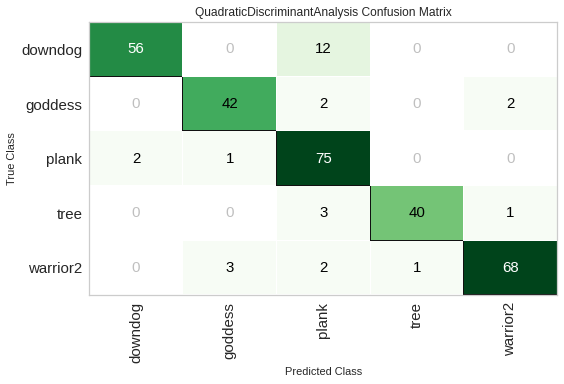

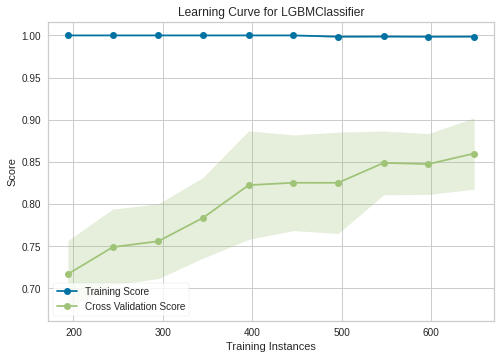

In [ ]:
evaluate_model(top_3_models[0])

In [ ]:
predict_model(top_3_models[0])

# Blending


In [ ]:
blended = blend_models(estimator_list=top_3_models, 
                       fold=10, # default
                       optimize='Accuracy',
                       method = 'hard')

In [ ]:
final_blended = finalize_model(blended)
print(final_blended)

In [ ]:
predict_model(final_blended)

In [ ]:
holdout_data = yp_df.sample(frac=0.10, random_state=0).reset_index(drop=True)

unseen_predictions = predict_model(final_blended, data=holdout_data)
unseen_predictions

In [ ]:
save_model(final_blended, 'final_blended')

In [ ]:
!cp "./final_blended.pkl" "$drive_path"

In [ ]:
from google.colab import files
#files.download('final_blended.pkl')

In [ ]:
from pycaret.classification import load_model
yoga_model_path = drive_path + '/final_blended.pkl'
yoga_path = drive_path + '/fitness_poses_csvs_out_TEST.csv'
!cp "$yoga_path" .
!cp "$yoga_model_path" .


In [ ]:
loaded_model = load_model('final_blended')

In [ ]:
yoga_path = drive_path + '/fitness_poses_csvs_out_TEST.csv'
!cp "$yoga_path" .

In [ ]:
yp_df = pd.read_csv("fitness_poses_csvs_out_TEST.csv",header=None)
yp_df = yp_df.rename(columns={0:'name', 1:'pose'})
yp_data_df = yp_df.drop(['name'], axis=1)

holdout_data = yp_data_df.sample(frac=0.10, random_state=0).reset_index(drop=True)

unseen_predictions = predict_model(loaded_model, data=holdout_data)
unseen_predictions

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['pose'], unseen_predictions['Label'], metric = 'Accuracy')